In [5]:
!python --version

Python 3.12.1


In [67]:
import pandas as pd
import numpy as np
import joblib

# Dataviz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from plotly.offline import plot
import seaborn as sns

# model
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
import pickle


In [7]:
# !pip list -o

In [47]:
df = pd.read_csv('../datasets/Student_performance_data _.csv')

1. <p>Olhar para o quadro geral; </p>
2. <p>Obter os dados;</p>
3. <p>Descobrir e visualizar os dados para obter informações; </p>
4. <p>Preparar os dados para os algoritmos do Aprendizado de Máquina; </p>
5. <p>Selecionar e treinar um modelo;</p>
6. <p>Ajustar o seu modelo; </p>
7. <p> Apresentar sua solução;</p>
8. <p>Lançar, monitorar e manter seu sistema.</p>

# Vizualização de dados para exploração

In [9]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [48]:
df = df.drop(columns='StudentID')
df = df.drop(columns='GPA')

## Análise visual dos dados

#### Análise de Grade Class por idade

In [11]:
df_Gc_age = pd.crosstab(index=df['GradeClass'], columns=df['Age'], values=df['Age'], aggfunc='count')
df_Gc_age

Age,15,16,17,18
GradeClass,,,,
0.0,27,29,24,27
1.0,70,72,60,67
2.0,103,87,100,101
3.0,108,98,122,86
4.0,322,307,281,301


In [12]:
def plotar_gc_idade(y):
  fig = px.bar(df_Gc_age, x=df_Gc_age.index, y=y, barmode='stack', color=df_Gc_age.index, height=400)
  fig.update_layout(
      title=f'Grade Class dos alunos de {y} anos' + '<br><sup size=1 style="color:#555655">Gráfico de contagem</sup></br>',
      font_family='sans-serif',
      title_font_size=20,
      title_font_color='#000000',
      xaxis_title='Grade Class'
  )
  return fig.show()

In [13]:
# 15 anos
plotar_gc_idade(15)

In [14]:
# 16 anos
plotar_gc_idade(16)

In [15]:
# 17 anos
plotar_gc_idade(17)

In [16]:
# 18 anos
plotar_gc_idade(18)

A distribuição do grade class por idade está semelhante, porém, aos 17 anos o gc 4 tem uma baixa notável

#### Análise de alunos que fazem atividades extra curriculares e o desempenho

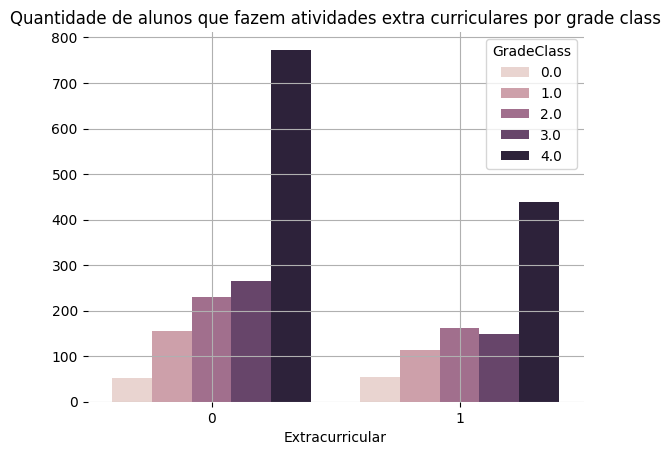

In [17]:
fig, ax = plt.subplots()
sns.countplot(x='Extracurricular', hue='GradeClass', data=df, ax=ax)
ax.set_title('Quantidade de alunos que fazem atividades extra curriculares por grade class')
ax.set_ylabel('')
ax.set_frame_on(False)
ax.grid(True)
plt.show()

In [18]:
df['Extracurricular'].value_counts()

Extracurricular
0    1475
1     917
Name: count, dtype: int64

Existe mais alunos que não fazem atividades extra curriculares, porém, alunos que não praticam atividade extracurricular tem um desempenho mais baixo

#### Tempo de estudo vs GPA

In [19]:
fig = px.scatter(x=df['GPA'].values, y=df['StudyTimeWeekly'].values, trendline='ols', trendline_color_override='red')
fig.update_layout(
    title='Tempo de estudo por semana por GPA' + '<br><sup size=1 style="color:#555655">Gráfico de dispersão</sup></br>',
    font_family='sans-serif',
    title_font_size=20
)

Não possui nenhuma correlação linear

#### Faltas vs GPA

In [20]:
df_faltas = df.groupby('GradeClass')[['Absences']].count()
df_faltas

,Absences
GradeClass,
0.0,107
1.0,269
2.0,391
3.0,414
4.0,1211


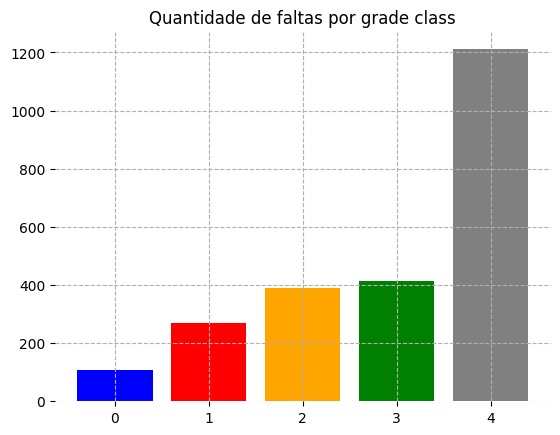

In [21]:
fig, ax = plt.subplots()
ax.grid(True, linestyle='--')
ax.bar(x=df_faltas.index, height=df_faltas['Absences'], data=df_faltas, color=['blue', 'red', 'orange', 'green', 'grey'])
ax.set_title('Quantidade de faltas por grade class')
ax.set_ylabel('')
ax.set_frame_on(False)
plt.show()

A classe com o maior número de faltas é a de menor desempenho

#### Alunos praticantes de música e o seu desempenho

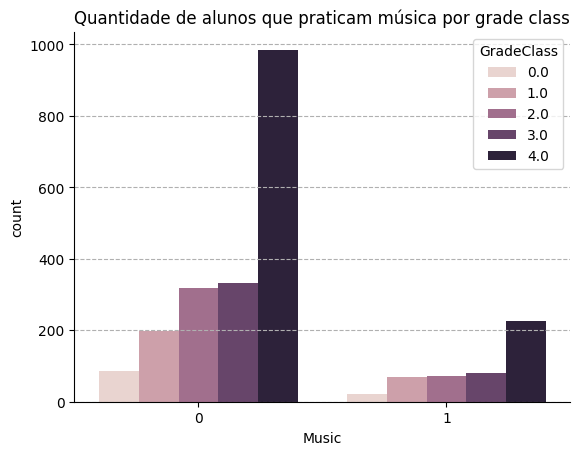

In [22]:
fig = sns.countplot(x='Music', hue='GradeClass', data=df)
fig.set_title('Quantidade de alunos que praticam música por grade class')
sns.despine(top=True, right=True)
fig.grid(visible=True, axis='y', linestyle='--')
plt.show()

In [23]:
print('A quantidade de alunos que não praticam musica é de {:.2f}%'.format(round(df["Music"].value_counts(normalize=True)[0]*100)))

A quantidade de alunos que não praticam musica é de 80.00%


#### Parental Educational

In [24]:
df_educacao = pd.crosstab(index=df['GradeClass'], columns=df['ParentalEducation'], values=df['ParentalEducation'], aggfunc='count')
df_educacao

ParentalEducation,0,1,2,3,4
GradeClass,,,,,
0.0,11,30,48,16,2
1.0,27,85,108,40,9
2.0,42,127,156,53,13
3.0,39,136,150,67,22
4.0,124,350,472,191,74


In [25]:
escolaridade = ['None', 'Hight School', 'Some College', 'Bachelor', 'Higher']
def educacao(y):
  fig, ax = plt.subplots()
  sns.barplot(x=df_educacao.index, y=df_educacao[y], data=df_educacao, ax=ax)
  ax.set_title(f'Média de notas de acordo com a escolaridade dos pais \nEscolaridade nível {y}, correspondente a {escolaridade[y]}')
  ax.set_ylabel('')
  ax.set_frame_on(False)
  ax.grid(True)
  return plt.show()

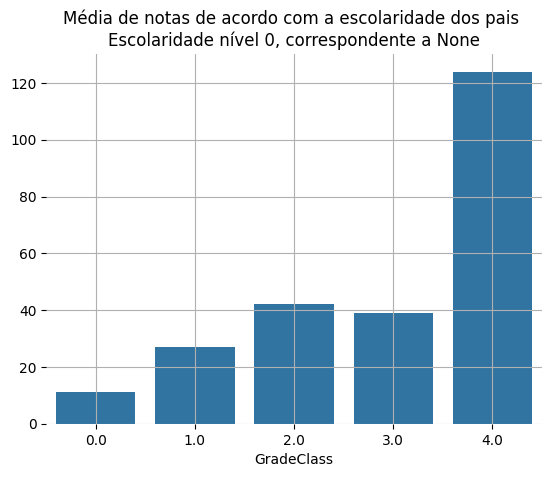

In [26]:
# Educacao nível 0
educacao(0)

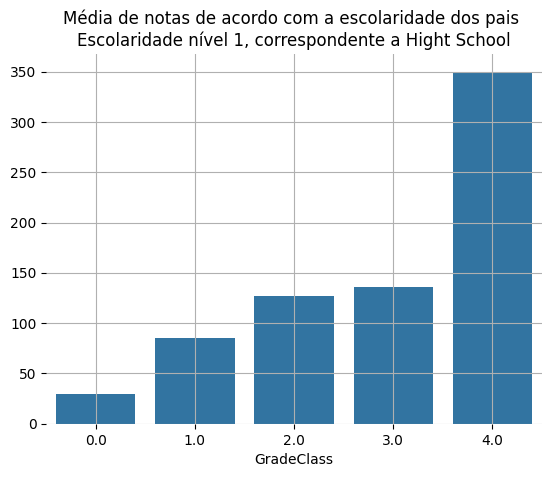

In [27]:
# Escolaridade nível 1
educacao(1)

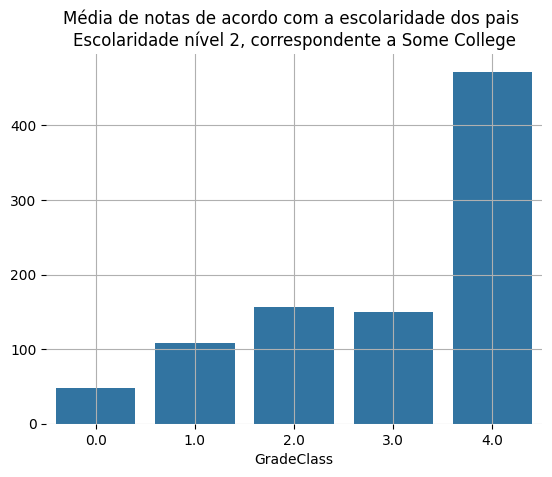

In [28]:
# escolaridade nível 2
educacao(2)

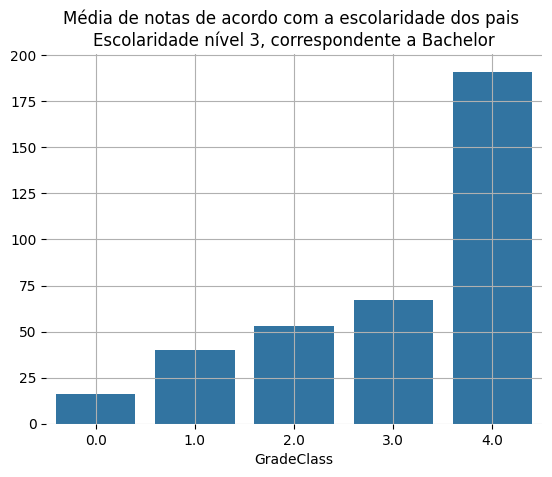

In [29]:
# escolaridade nível 3
educacao(3)

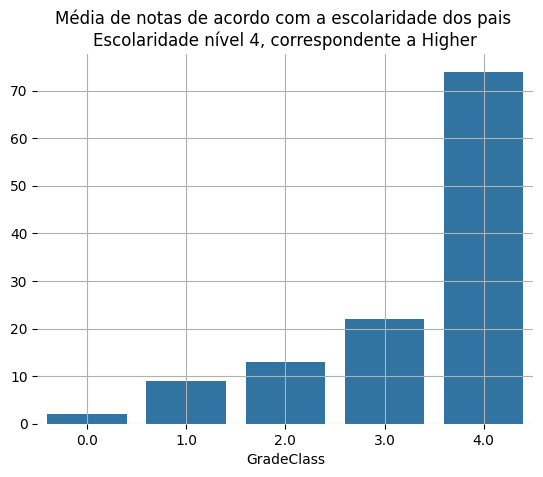

In [30]:
# escolaridade nível 4
educacao(4)

In [31]:
df['ParentalEducation'].value_counts()

ParentalEducation
2    934
1    728
3    367
0    243
4    120
Name: count, dtype: int64

Distribuição semelhante entre as escolaridades sendo que temos um número maior de alunos no qual os país tem escolaridade nível 2

#### Análise de correlação linear

In [32]:
df_corr = df.corr()
fig = px.imshow(df_corr, color_continuous_scale='RdBu', height=550)
fig.update_layout(
    title='Matriz de correlação linear',
    font_family='sans-serif',
    title_font_size=20
)
fig.show()

In [33]:
comentario = '''Absences é proporcionalmente correlacional com o desempenho dos
alunos, bem como, o GPA que obviamente altera a váriavel Grade Class,
pois, grade class é uma sintese dessa variável. '''
print(comentario)

Absences é proporcionalmente correlacional com o desempenho dos
alunos, bem como, o GPA que obviamente altera a váriavel Grade Class,
pois, grade class é uma sintese dessa variável. 


In [34]:
comentario_2 = '''O que a correlação linear leva a entender é que o unicao fator
que interfere no desempenho dos alunos é o número de faltas.'''
print(comentario_2)

O que a correlação linear leva a entender é que o unicao fator
que interfere no desempenho dos alunos é o número de faltas.


### Verificando distribuição das variáveis do df

In [35]:
def distribuicao(df):
  for col in df.columns:
    print(f'Valores {round(df[col].value_counts(normalize=True, )*100, 2)}')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')
  distribuicao_list = [list(np.round(df[col].value_counts(normalize=True).values, 2)) for col in df.columns]
  return distribuicao_list

distribuicao_lista = distribuicao(df)

Valores Age
15    26.34
16    24.79
17    24.54
18    24.33
Name: proportion, dtype: float64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Valores Gender
1    51.09
0    48.91
Name: proportion, dtype: float64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Valores Ethnicity
0    50.46
1    20.61
2    19.65
3     9.28
Name: proportion, dtype: float64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Valores ParentalEducation
2    39.05
1    30.43
3    15.34
0    10.16
4     5.02
Name: proportion, dtype: float64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Valores StudyTimeWeekly
17.819907    0.04
19.833723    0.04
15.408756    0.04
4.210570     0.04
10.028829    0.04
             ... 
2.252185     0.04
18.679748    0.04
3.671593     0.04
5.055317     0.04
8.132731     0.04
Name: proportion, Length: 2392, dtype: float64
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Valores Absences
13    3.89
25    3.89
12    3.85
8     3.80
20    3.76
19    3.76
6     3.68
15    3.64
23    3.60
7     3.60
1     3.55
14    3.51
27    3.51
21    3.47
5     3.47
17

A distribuição dos itens das colunas estão tendendo ao 0, ou seja, correspondente ao 'não' da base de dados.
Variável target desbalanceada, teremos que usar bibliotecas de balanceamento como a biblioteca imblearn.

## Balanceando dados

In [49]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### K means Smote


In [51]:
sm = KMeansSMOTE(k_neighbors=3, sampling_strategy='not majority', cluster_balance_threshold=0.13)
model = HistGradientBoostingClassifier(random_state=42)

pipline = make_pipeline_imblearn(sm, model)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_kmeans = cross_val_score(pipline, X, y, cv=cv)
print(f'A acurácia é igual a {cv_kmeans.mean()*100:.3f}%')


c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



A acurácia é igual a 69.398%


### Cálculo do peso das classes

In [52]:
model = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cval = cross_val_score(model, X, y, cv=cv)
print(f'A acurácia é igual a {cval.mean()*100:.3f}%')

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



A acurácia é igual a 70.275%


### Oversampling SMOTE

In [53]:
sm = SMOTE(k_neighbors=3, sampling_strategy='not majority')
model = HistGradientBoostingClassifier(random_state=42)

pipline = make_pipeline_imblearn(sm, model)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_kmeans = cross_val_score(pipline, X, y, cv=cv)
print(f'A acurácia é igual a {cv_kmeans.mean()*100:.3f}%')


c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



A acurácia é igual a 68.060%


# Seleção de paramêtros

In [54]:
inner_cv = StratifiedKFold(shuffle=True)
outer_cv = StratifiedKFold(n_splits = 3, shuffle=True)

In [61]:
hgbc = HistGradientBoostingClassifier(class_weight='balanced')

params = {
    'max_iter':np.arange(100, 600, 50),
    'max_leaf_nodes':np.arange(20, 30, 5),
    'max_depth':np.arange(10, 40, 5),
    'min_samples_leaf':np.arange(10, 30, 5),
    'random_state':np.arange(30, 500, 5),
    'warm_start':[True,False],
}

hgbc_random = RandomizedSearchCV(hgbc, param_distributions=params, n_iter=25, cv=inner_cv, n_jobs=-1)
cv_hgbc = cross_val_score(hgbc_random, X, y, cv=outer_cv, n_jobs=-1)


In [63]:
print(f'Acúracia média: {cv_hgbc.mean()*100:.2f}%')
print(f'Intervalo de confiança: {round(cv_hgbc.mean() - 2 * cv_hgbc.std(), 4)} - {round(2 * cv_hgbc.std() + cv_hgbc.mean(), 4)}')

Acúracia média: 69.52%
Intervalo de confiança: 0.6858 - 0.7047


In [64]:
hgbc_random.fit(X, y)

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=HistGradientBoostingClassifier(class_weight='balanced'),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15, 20, 25, 30, 35]),
                                        'max_iter': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550]),
                                        'max_leaf_nodes': array([20, 25]),
                                        'min_samples_leaf': array([10, 15...
        95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155,
       160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220,
       225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285,
       290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350,
       355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415,
       420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480,
       485, 490, 495]),
                                        'warm_start': [True, False]})

In [65]:
hgbc = HistGradientBoostingClassifier(**hgbc_random.best_params_)
hgbc.fit(X_train, y_train.values.reshape(-1))

HistGradientBoostingClassifier(max_depth=np.int64(20), max_iter=np.int64(100),
                               max_leaf_nodes=np.int64(25),
                               min_samples_leaf=np.int64(20),
                               random_state=np.int64(175))

In [70]:
preds = hgbc.predict(X_test)
acuracia = accuracy_score(y_test, preds)
# f1 = f1_score(y_test, preds)
print(f'A acurácia é igual a {acuracia*100:.2f}%')

A acurácia é igual a 72.86%


In [69]:
dummie = DummyClassifier(strategy='most_frequent')
dummie.fit(X_train, y_train)
preds = dummie.predict(X_test)
accuracy_score(y_test, preds)

0.5073068893528184

In [71]:
with open('hgbc_model.pkl', 'wb') as arquivo:# Escrever arquivo
  pickle.dump(hgbc, arquivo)

### Voting Classifier

In [38]:
melhores_modelos = pd.DataFrame(hgbc_random.cv_results_).sort_values(by='rank_test_score').head()

In [39]:
melhores = [HistGradientBoostingClassifier(**params) for params in melhores_modelos['params']]
modelos = [(f'modelo{i}', modelo.fit(X_train, y_train.values.reshape(-1))) for i, modelo in enumerate(melhores)]

In [40]:
from sklearn.ensemble import VotingClassifier

votacao = VotingClassifier(estimators=modelos,
                           voting='soft')
cv_votacao = cross_val_score(votacao, X, y.values.reshape(-1), cv=outer_cv)

In [41]:
print(f'A pontuação média é de {round(cv_votacao.mean(), 5)*100}%')

A pontuação média é de 91.597%


In [42]:
parametros = {
    'voting':['hard', 'soft'],
    'weights':[np.random.randint(1, len(modelos), size=(1, len(modelos)))[0] for i in range(3125)]
}

random_votacao = RandomizedSearchCV(votacao, param_distributions=parametros, n_iter=4, cv=inner_cv, n_jobs=-1)
cv_votacao = cross_val_score(random_votacao, X, y.values.reshape(-1), cv=outer_cv)

c:\Users\lucas\virtual env global\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [49]:
f'{cv_votacao.mean()*100:.2f}%'

'91.85%'

Exportando HGBC